# MinHashing  using  LSH package

In [58]:
import sys
import os
import mmh3
import numpy as np
import itertools
import collections
import argparse
import snapy
import pandas as pd
from datasketch import MinHash
from datasketch import MinHashLSH
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import pandas as pd
import os
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
import re
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import LdaMulticore, LdaModel
import sys
import pandas as pd
import scipy as sc
import scipy.sparse as sparse
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils as genmath
from gensim import corpora, models
import gensim
from gensim import corpora, models
from collections import Counter

In [59]:
#import the document of stopwords 
stop = set(stopwords.words('english'))

In [60]:
#import our dataset and then put them into the dataframe 
data = pd.read_csv("E:\\plagiarism_detection\\articles1.csv", sep=',')
data_content = data["content"] #we are only interested in the content in each news

In [61]:
#Preprocess each document.
def clean(text):
    tokens = word_tokenize(text)
    # Remove the punctuations
    tokens = [word for word in tokens if word not in stop and len(word) > 2]
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
    tokens = [word for word in tokens if not word in stop]
   
    return tokens

In [62]:
#Create a new dictionary to store each cleaned document.
docs1={}
for i in data_content.index:  
    cleaned = clean(data_content[i])   
    docs1[i] = str([' '.join(cleaned)])

In [63]:
#The function to create shingles for each document
def hashed_lst_shingles(q, doc):
    
    doc = doc.split(" ")
    lst_shingles=[]

    lst_shingles = [doc[i:i+q] for i in range(0, len(doc), q-2)] # create list of shingles of length q

    lst_shingles = [x for x in lst_shingles if len(x)==q] # remove shingles with length < q

    return lst_shingles 

In [64]:
#Create a dictionary to store the list of shingles for each document.
docs_clean = {}
count = 1
for i,k in docs1.items():
  docs_clean["m{0}".format(count)] = hashed_lst_shingles(3,k) #We set the size of shingle as 3, and give each document a id for example the first document is "m1"
  count +=1 

In [65]:
#Check whether we successfully create shingles for each document.
docs_clean['m3']

[["['walt", 'disney', 'bambi'],
 ['disney', 'bambi', 'opened'],
 ['bambi', 'opened', '1942'],
 ['opened', '1942', 'critics'],
 ['1942', 'critics', 'praised'],
 ['critics', 'praised', 'spare'],
 ['praised', 'spare', 'haunting'],
 ['spare', 'haunting', 'visual'],
 ['haunting', 'visual', 'style'],
 ['visual', 'style', 'vastly'],
 ['style', 'vastly', 'different'],
 ['vastly', 'different', 'anything'],
 ['different', 'anything', 'disney'],
 ['anything', 'disney', 'done'],
 ['disney', 'done', 'know'],
 ['done', 'know', 'film'],
 ['know', 'film', 'striking'],
 ['film', 'striking', 'appearance'],
 ['striking', 'appearance', 'created'],
 ['appearance', 'created', 'chinese'],
 ['created', 'chinese', 'immigrant'],
 ['chinese', 'immigrant', 'artist'],
 ['immigrant', 'artist', 'took'],
 ['artist', 'took', 'inspiration'],
 ['took', 'inspiration', 'landscape'],
 ['inspiration', 'landscape', 'paintings'],
 ['landscape', 'paintings', 'song'],
 ['paintings', 'song', 'dynasty'],
 ['song', 'dynasty', 'ext

In [66]:
'''num_perm is the number of permutations we want for the MinHash algorithm ,the higher the permutations the longer the runtime.
   min_dict1 maps each documents with the form of shingles to min hash signatures. We loop through all the set representations of 
   questions and calculate the signatures and store them in the min_dict1 dictionary'''

num_perm = 100
min_dict1 = {}
count3 = 1
for val in tqdm(docs_clean.values()):
    m = MinHash(num_perm=num_perm)
    for shingle in val:    
      a= []
      for i in shingle:
        i.encode('utf8')
        a.append(i)
      data1 = str(['_'.join(a)]) #Cause the size of our shingles is 3, so we need to the shingle with the form of "shingle_shingle_shingle"

      m.update(data1.encode('utf8'))
    min_dict1["m{}".format(count3)] = m
    count3+=1

100%|██████████| 50000/50000 [05:20<00:00, 156.15it/s]


In [67]:
'''We set the Jaccard similarity threshold as a parameter in MinHashLSH. We loop through the signatures or keys 
   in the min_dict dictionary ,Datasketch stores these in a dictionary format, where the key is a document
   and the value is other documents deemed similar based on the threshold. '''    
lsh = MinHashLSH(threshold=0.54, num_perm=num_perm)
for key in tqdm(min_dict1.keys()):
    lsh.insert(key,min_dict1[key]) # insert minhash data structure

100%|██████████| 50000/50000 [00:05<00:00, 9836.71it/s] 


In [68]:
# This function works with the dictionary output of the LSH to to output candidate pairs.
 def create_cand_pairs():
    big_list = []
    for query in min_dict1.keys():
        bucket = lsh.query(min_dict1[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

In [69]:
pairs = create_cand_pairs() #Create candidate pairs.
pairs1 = [i for i in pairs if i[1] != 'None'] #Remove pairs contain "None".

In [70]:
len(pairs1)

16606

 We found that there are so many repetitive pairs so that we have to remove those repetitive pairs

In [71]:
pairs1

[['m134', 'm4924'],
 ['m813', 'm846'],
 ['m813', 'm846'],
 ['m32722', 'm1163'],
 ['m43299', 'm23228'],
 ['m43299', 'm44515'],
 ['m43299', 'm45950'],
 ['m43299', 'm45456'],
 ['m43299', 'm48523'],
 ['m43299', 'm45605'],
 ['m43299', 'm45216'],
 ['m43299', 'm44505'],
 ['m43299', 'm47492'],
 ['m43299', 'm45342'],
 ['m43299', 'm16257'],
 ['m43299', 'm44929'],
 ['m43299', 'm26099'],
 ['m43299', 'm47821'],
 ['m43299', 'm28835'],
 ['m43299', 'm46018'],
 ['m43299', 'm16724'],
 ['m43299', 'm30752'],
 ['m43299', 'm20084'],
 ['m43299', 'm48582'],
 ['m43299', 'm18373'],
 ['m43299', 'm45610'],
 ['m43299', 'm47986'],
 ['m43299', 'm42039'],
 ['m43299', 'm47847'],
 ['m43299', 'm46088'],
 ['m43299', 'm47792'],
 ['m43299', 'm45740'],
 ['m43299', 'm45126'],
 ['m43299', 'm46375'],
 ['m43299', 'm47591'],
 ['m43299', 'm43516'],
 ['m43299', 'm29814'],
 ['m43299', 'm46969'],
 ['m43299', 'm30001'],
 ['m43299', 'm45466'],
 ['m43299', 'm47594'],
 ['m43299', 'm26579'],
 ['m43299', 'm30937'],
 ['m43299', 'm13010'],


In [72]:
#Create a list to store unique candidate pairs.
candidate_pairs = []
for i in pairs1:
    if i not in candidate_pairs:
        candidate_pairs.append(i)

In [73]:
len(candidate_pairs)

455

In [74]:
candidate_pairs #Each pair is similar documents .

[['m134', 'm4924'],
 ['m813', 'm846'],
 ['m32722', 'm1163'],
 ['m43299', 'm23228'],
 ['m43299', 'm44515'],
 ['m43299', 'm45950'],
 ['m43299', 'm45456'],
 ['m43299', 'm48523'],
 ['m43299', 'm45605'],
 ['m43299', 'm45216'],
 ['m43299', 'm44505'],
 ['m43299', 'm47492'],
 ['m43299', 'm45342'],
 ['m43299', 'm16257'],
 ['m43299', 'm44929'],
 ['m43299', 'm26099'],
 ['m43299', 'm47821'],
 ['m43299', 'm28835'],
 ['m43299', 'm46018'],
 ['m43299', 'm16724'],
 ['m43299', 'm30752'],
 ['m43299', 'm20084'],
 ['m43299', 'm48582'],
 ['m43299', 'm18373'],
 ['m43299', 'm45610'],
 ['m43299', 'm47986'],
 ['m43299', 'm42039'],
 ['m43299', 'm47847'],
 ['m43299', 'm46088'],
 ['m43299', 'm47792'],
 ['m43299', 'm45740'],
 ['m43299', 'm45126'],
 ['m43299', 'm46375'],
 ['m43299', 'm47591'],
 ['m43299', 'm43516'],
 ['m43299', 'm29814'],
 ['m43299', 'm46969'],
 ['m43299', 'm30001'],
 ['m43299', 'm45466'],
 ['m43299', 'm47594'],
 ['m43299', 'm26579'],
 ['m43299', 'm30937'],
 ['m43299', 'm13010'],
 ['m43299', 'm23999

In [77]:
for i in candidate_pairs:
    if i[1] == 'm41116':
        print(i)

['m41048', 'm41116']


# Topic Modeling

In [8]:
#Create an object of corpora.Dictionary()
dictionary = corpora.Dictionary()

In [9]:
#Build a list to store the tokenized words for each document
data_tokenized = []

In [10]:
#Clean the words in each docuemnt and then add them into the list
for i in data_content.index:  
    cleaned = clean(data_content[i])   
    data_tokenized.append(cleaned)

In [12]:
#We need to pass these tokenized words into dictionary.doc2bow() object
BoW_corpus = [
   dictionary.doc2bow(doc, allow_update=True) for doc in data_tokenized
]

In [79]:
#Apply the LDA algorithm
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=10)

In [80]:
#Calculate the topic probality for each document
topic_prob =lda_model.get_document_topics(BoW_corpus ) 

In [81]:
#To check whether topic_prob includes all the documents in our dataset
len(topic_prob)

50000

In [82]:
#Create a dic to store the topic for each dicument, we take the topic with the biggest probability as the topic of that document.
topic_document = {}
for i in enumerate(topic_prob):
    max = 0
    for j in i[1]:
        if j[1] > max:
            max = j[1]
            topic_document[i[0]] = j[0]

In [83]:
#This is the general view of topics for each document
print(topic_document)

{0: 9, 1: 1, 2: 3, 3: 3, 4: 6, 5: 3, 6: 6, 7: 8, 8: 3, 9: 3, 10: 8, 11: 8, 12: 5, 13: 8, 14: 3, 15: 3, 16: 1, 17: 8, 18: 2, 19: 0, 20: 3, 21: 3, 22: 2, 23: 3, 24: 4, 25: 4, 26: 2, 27: 2, 28: 2, 29: 2, 30: 3, 31: 2, 32: 8, 33: 1, 34: 1, 35: 8, 36: 3, 37: 3, 38: 3, 39: 6, 40: 3, 41: 4, 42: 4, 43: 5, 44: 4, 45: 2, 46: 7, 47: 8, 48: 5, 49: 3, 50: 3, 51: 8, 52: 6, 53: 1, 54: 3, 55: 3, 56: 3, 57: 4, 58: 9, 59: 4, 60: 5, 61: 6, 62: 1, 63: 2, 64: 2, 65: 3, 66: 3, 67: 3, 68: 0, 69: 3, 70: 8, 71: 6, 72: 8, 73: 6, 74: 8, 75: 6, 76: 1, 77: 5, 78: 8, 79: 6, 80: 3, 81: 8, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 5, 88: 6, 89: 6, 90: 2, 91: 9, 92: 6, 93: 5, 94: 3, 95: 6, 96: 8, 97: 1, 98: 8, 99: 8, 100: 3, 101: 8, 102: 2, 103: 3, 104: 8, 105: 1, 106: 3, 107: 1, 108: 3, 109: 6, 110: 5, 111: 9, 112: 6, 113: 6, 114: 5, 115: 6, 116: 5, 117: 0, 118: 8, 119: 8, 120: 1, 121: 8, 122: 1, 123: 3, 124: 3, 125: 9, 126: 2, 127: 5, 128: 1, 129: 8, 130: 8, 131: 3, 132: 8, 133: 3, 134: 3, 135: 5, 136: 4, 137: 1, 138: 

In [85]:
#We add the topics for each document into one list, so we could counter the number for each topic.
topic_num = []
for k,v in topic_document.items():
    topic_num.append(v)

In [88]:
#Counter the number for each topic.
topic_counter = Counter(topic_num)
topic_counter.most_common()

[(3, 8948),
 (5, 8930),
 (2, 6309),
 (4, 5773),
 (1, 5574),
 (8, 5250),
 (9, 3807),
 (6, 2871),
 (7, 1463),
 (0, 1075)]

In [123]:
#Add the number of documents for each topic to the list in the order of natural number.
topic_num_list = []
for i in range(10):
    topic_num_list.append(topic_counter[i])
topic_num_list

[1075, 5574, 6309, 8948, 5773, 8930, 2871, 1463, 5250, 3807]

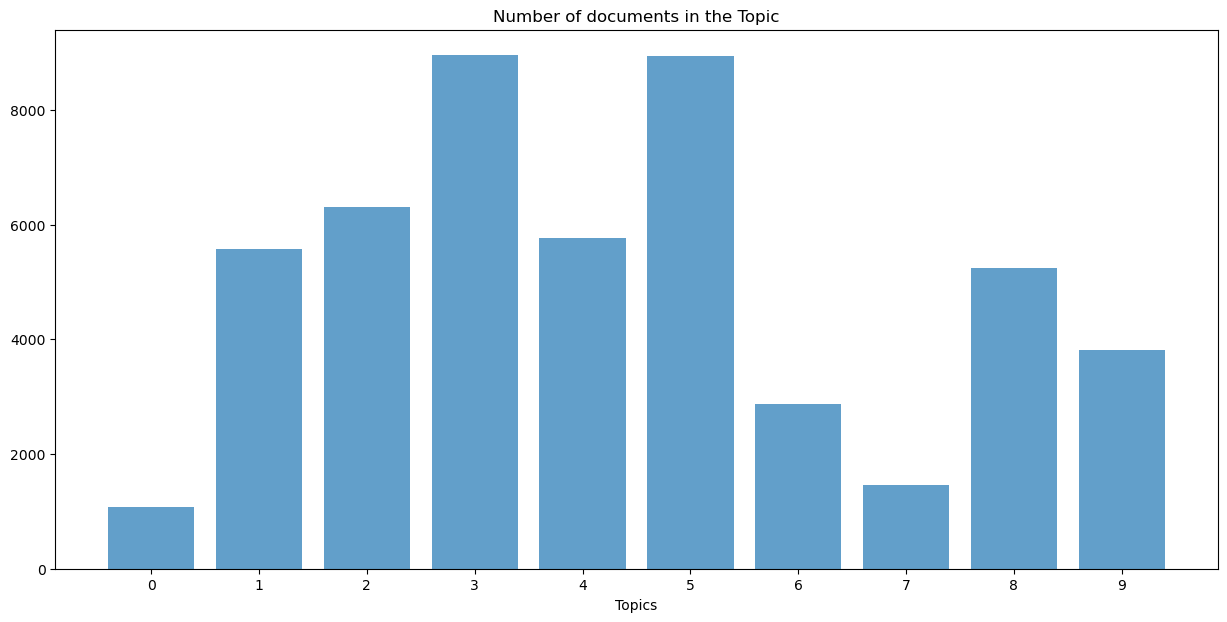

In [90]:
#Build a histogram to show the number of docuemnts for each topic.
from matplotlib import pyplot as plt
from matplotlib import font_manager
 
plt.figure(figsize=(15,7)) 
plt.bar(range(10),topic_num_list,align='center', alpha=0.7, ecolor='black', capsize=10)
plt.xticks(range(10),range(10))
plt.xlabel("Topics")
plt.title('Number of documents in the Topic')
plt.show()